In [1]:
import import_ipynb
import plotting
import finite_difference_functions as fd_fct
import misc_functions as msc_fct
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import axes3d

importing Jupyter notebook from plotting.ipynb
importing Jupyter notebook from finite_difference_functions.ipynb
importing Jupyter notebook from misc_functions.ipynb


## Parametisation ##

In [2]:
# initial various parameters
T = 60
Ndt = 6000
dt = T / Ndt

t = np.arange(0, T + dt, dt)
tau = T - t

# price jump sizes
sigma = 0.01

kappa = 100
xi = 0.01
alpha = 0.001

lamb = 50 / 60
Nq = 10
q = np.arange(0, Nq + 1, 1)
phi = 0.001

# AC Solution
phiAC = 10 ** (-5)
aAC = 0.001

qAC = msc_fct.AC_solver(phiAC, aAC, tau, T, Nq)

# solve the QVI for omega
omega, exe = fd_fct.QVI_solver(t, dt, kappa, xi, phi, q, qAC, lamb)

# obtain the optimal time at which to execute market orders
t_opt = fd_fct.find_opt_t(exe, t)

# Solve for delta
delta = fd_fct.find_delta(kappa, omega, Nq, Ndt)

##### Market orders vs target liquidation schedule

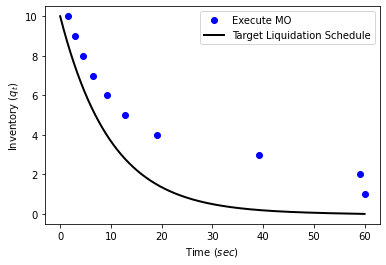

In [3]:
plotting.plot_opt(t_opt[1:], q[1:], qAC, t)

##### Deltas

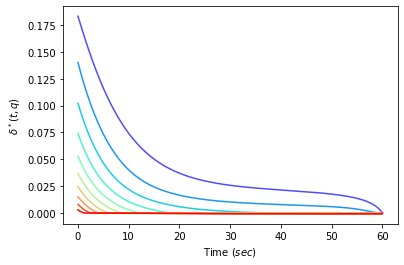

In [4]:
plotting.plot_multi_lines(t[0:(t.shape[0]-1)], delta[:, 0:(delta.shape[1]-1)],  xlab=r"Time ($sec$)", ylab=r"$\delta^*(t,q)$")

### Sample paths

In [5]:
np.random.seed(10)

# Number of Simulations
Nsims = 1000

# The Mid-price to start with
s0 = 1

deltaPath, Qpath, isMO, Xpath, Spath, pricePerShare, twap, V = fd_fct.generate_simulations(Nsims, s0, Ndt, Nq, dt, delta, lamb, kappa, sigma, xi, t_opt, t, omega)

In [6]:
# Choose the three simulation results
idx_fig = np.array([72, 57, 2])

##### Sample path depths

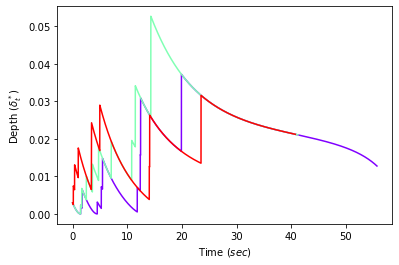

In [7]:
plotting.plot_multi_lines(t, deltaPath[idx_fig], r'Time ($sec$)', r'Depth ($\delta^*_t$)')

##### Sample path Value function

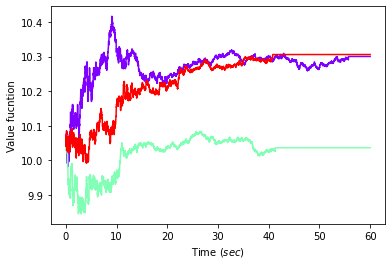

In [8]:
plotting.plot_multi_lines(t, V[idx_fig], r'Time ($sec$)', r'Value fucntion')

#### Value of value function

In [9]:
# inital value function
print(V[0,0])

10.041139926898735


##### Sample path inventory

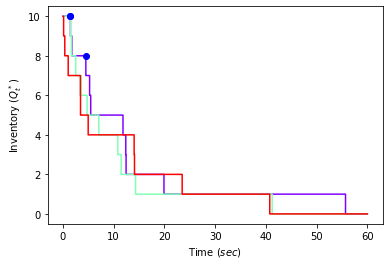

In [10]:
plotting.plot_inventory(isMO[idx_fig, :], Qpath[idx_fig, :], t)

##### Sample path cash balance

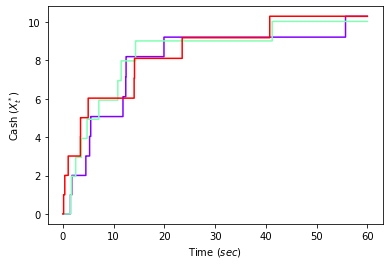

In [11]:
plotting.plot_multi_steps(t, Xpath[idx_fig, :], r'Time ($sec$)', r'Cash ($X^*_t$)')

##### Sample path mid-price

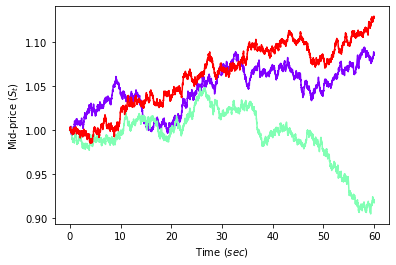

In [12]:
plotting.plot_multi_lines(t, Spath[idx_fig, :], r'Time ($sec$)', r'Mid-price ($S_t$)')

##### Sample path price per share vs twap

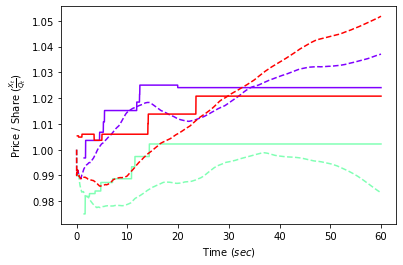

In [13]:
plotting.plot_price_per_share(t, pricePerShare[idx_fig, : ], twap[idx_fig, : ])
#looks dodgy

##### inventory heatmap

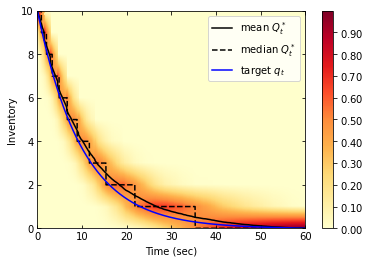

In [14]:
q = np.arange(0, Nq + 1, 1)
myn = np.full((Ndt + 1, Nq + 1), np.NaN)
for k in range(0, t.shape[0], 1):
    myn[k, :]  = np.histogram(Qpath[:, k], bins=np.append(q, Nq + 1))[0]
myn = np.transpose(myn)
medq = np.median(Qpath, axis=0)
meanq = np.mean(Qpath, axis=0)

plotting.plot_heat_map(t=t, q=q, myn_per_sim=myn / Nsims, meanq=meanq, medq=medq, qAC=qAC, xlab=r'Time (sec)', ylab=r'Inventory')

##### Price per share sold

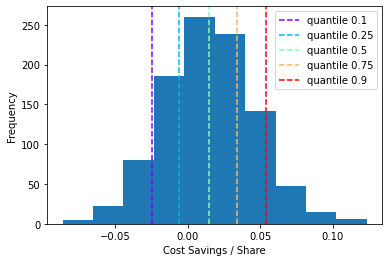

In [15]:
terminal_pps = pricePerShare[:,-1]
plotting.plot_histogram(terminal_pps - twap[:, twap.shape[1] - 1], r'Cost Savings / Share', np.array([0.1, 0.25, 0.5, 0.75, 0.9]))

##### Cost savings

In [16]:
print((terminal_pps - twap[:, twap.shape[1] - 1]).mean())

0.014798695861359764


#### How phi impacts MO

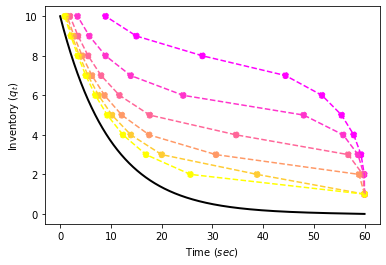

In [17]:
k = 6
idx = np.linspace(3, 1, k+3)
colour_idx = np.linspace(0, 1, k)
fig, ax = plt.subplots()
for m, i in zip(colour_idx, idx):
    phi_r = 20**(-i)
    omega, exe = fd_fct.QVI_solver(t, dt, kappa, xi, phi_r, q, qAC, lamb)
    t_opt_r = fd_fct.find_opt_t(exe, t)
    ax.scatter(t_opt_r[1:], q[1:], color=plt.cm.spring(m), linestyle='--')
    ax.plot(t_opt_r[1:], q[1:], color=plt.cm.spring(m), linestyle='--')
    #plot of avg price per share for each sample path vs TWAP
    
#plt.legend([line1, line2], ["Execute MO", "Target Liquidation Schedule"])
plt.ylabel(r'Inventory ($q_t$)')
plt.xlabel(r'Time ($sec$)')
ax.plot(t, qAC, 'k-', linewidth=2)
plt.show()